# Creating custom acausal components

This tutorial assumes that the reader is familiar with the potential/flow (also known as through/across) variable approach for acausal modeling. Briefly:
- Potential: 
    - Physically: a quantity that is measured using a sensor placed across the component.
    - Mathematically: a quantity that is the same at all ports connected at a node.
    - Examples: voltage, pressure, temperature difference, relative position/speed/acceleration.
- Flow:
    - Physically: a quantity that is measured using a sensor placed inline, in series with the component.
    - Mathematically: a quantity that sums to zero for all ports connected at a node.
    - Examples: current, mass flow, heat flow, force, torque.

From here on, acausal components will be referred to as 'components', so as not to be confused with 'blocks', which we use for causal modeling.

Components in collimator are not used directly for simulation. Components are first connected together to form an `AcausalDiagram`, which is compiled by `AcausalCompiler` to create an `AcausalSystem`. `AcausalSystem` is a subclass of `LeafSystem`, and hence the `AcausalSystem` is used directly in simulation. `AcausalSystem` contains the index-1 DAEs, events, etc. needed by the simulator to advance the acausal model in time.

The equations of components are all collected together to form the 'system of equations' for the acausal model. The `AcausalCompiler` requires that symbols of these equations all use some common sympy.Symbol objects when defining symbols and equations. For this reason, it is required that all the components of an `AcausalDiagram` share the same 'equation environment'. This is achieved by creating an instance of `EqnEnv` class by writting `ev = EqnEnv()`, and passing `ev` to initializers and class methods where necessary. `ev.t` is the symbol for 'time' used in all equations, this is one reason why `ev` is passed in almost everywhere. `ev` also contains some useful constants, see `EqnEnv` class for details.

All components in Collimator inherit from the base `ComponentBase` class. In order to implement a custom component, we can inherit from this base class and implement the functionality of the component. However, each domain provides subclasses of `ComponentBase` which can be used for creating one port or two port components for that domain with gerater ease.

As an example, the translational domain library includes `TranslationalOnePort` and `TranslationalTwoPort`, which can be used as follows to create custom components.

Use `TranslationalOnePort` to create a component which imposes aerodynamic drag force per: $ F _d = \frac{1}{2}*p*C _d*A*v^2 $.
```python
class AeroDrag(TranslationalOnePort):
    """
    Applies force equal to the aerodynamic drag based on the velocity of
    its port.
    """
    def __init__(self, 
        ev, 
        name=None, 
        p=1.2, # density of air, kg/m**3
        A=1.0, # cross sectional area, m**2
        Cd=0.1, # drag coefficient
    )
    self.name = self.__class__.__name__ if name is None else name
    super().__init__(ev,self.name)

    # Cd has been chosen as parameter available for optmization.
    # p and A are static, so the model must be recompiled if these are changed.
    self.Cd = self.declare_symbol(
        ev,
        "Cd",
        self.name,
        kind=SymKind.param,
        val=M,
        validator=lambda Cd: Cd > 0.0,
        invalid_msg=f"Component {self.__class__.__name__} {self.name} must have Cd>0",
    )

    # add the equation that defines the component behavior.
    self.add_eqs([sp.Eq(self.f.s, 0.5 * p * A * self.Cd * self.v.s**2)])
```

Use `TranslationalTwoPort` to create a fixed length bar with non-zero mass.
```python
class RigidBar(TranslationalTwoPort):
    """
    A rigid bar with length L, and mass M.
    """
    def __init__(self, 
        ev, 
        name=None,
        L=1.0,
        M=1.0,
        initial_velocity_A=0.0,
        initial_velocity_A_fixed=False,
        initial_position_A=0.0,
        initial_position_A_fixed=False,
    )
    self.name = self.__class__.__name__ if name is None else name
    super().__init__(
            ev,
            self.name,
            v1_ic=initial_velocity_A,
            v1_ic_fixed=initial_velocity_A_fixed,
            x1_ic=initial_position_A,
            x1_ic_fixed=initial_position_A_fixed,
            v2_ic=initial_velocity_A,
            v2_ic_fixed=initial_velocity_A_fixed,
            x2_ic=initial_position_A + L,
            x2_ic_fixed=initial_position_A_fixed,
        )

    # The component equation 0 = f1 + f1 was inherited from TranslationalTwoPort.
    # Note: neither L nor M may be modified in optimization.
    self.add_eqs(
            [
                sp.Eq(self.x1.s + L, self.x2.s),
                sp.Eq(self.v1.s, self.v2.s),
                sp.Eq(self.a1.s, self.a2.s),
                sp.Eq(self.f1.s, M * self.a1.s),
            ]
        )
```

As noted in the comments, declaring parameters using the `declare_symbol` method is necessary if (i) automatic differentiation with respect to these parameters is required; or (ii) the parameters need to be updated in the context. If these are not requirements, the parameters can be used in equations directly, or stored as instance attributes for other uses.



## ComponentBase implementation

In order to implement components with more ports, or ports from multiple domains, we need to inherit from the `ComponentBase` class. While we refer to the documentation of the `ComponentBase` class for full details, here we provide an overview of basic functionality followed by a complete component example.

### Acausal ports
To delcare a port, we use the `declare_<domain>_port` methods, and pass the appropriate arguments for the port domain. These methods will declare necessary symbols, declare any require derivative relationshsips between them, and return the symbols for potential and flow variables at the port. For example, to add an electrical port to our component we can write `port_v, port_i = self.declare_electrical_port(ev, 'plus')` in the initializer of the ComponentBase subclass. The port object added is then accessible by writing `self.ports['plus']`.

### Parameters

As shown in the component examples above, parameters of components may be either static or dynamic. 
To declare a parameter, we use the `declare_symbol` method, and pass in the appropriate arguments for a parameter. See `Sym` class for details. For example, to declare a parameter $a$ with a scalar value of 1.0, we can write `a = self.declare_symbol(ev, "a", self.name, val=1.0)` in the initializer of the ComponentBase subclass. The returned object cannot be directly used in the component equations, but rather the sympy.symbol attribute of the object, e.g. `a.s`.

### Equations
`AcausalCompiler` handles equations which serve many different purposes in the context of the 'system of equations' for the acausal model. Some equations are defined by the components, while others are added by `AcausalCompiler` to complete the 'system of equations'. The available equation kinds are listed in the `EqnKind` class.
#### Component Equations
The behavior of components is realized by the 'component equations', identified by the `EqnKind.comp` kind. Component equations are necessary to define the relationship(s) between the potential and flow variables at the components' ports. Component equations can be declared by writting `self.eqs([sp.Eq(Sym1.s, Sym2.s + Sym3.s)])`. Note that a list is passed as the argument to this method, any number of component equations can be included in the list. Note that these equations will be classed as 'component equations' with the `EqnKind.comp` kind, so any equation which should not have this classification should not be included in the list.
#### Output Equations
In order to have `AcausalSystem` include a variable as a causal output, it is necessary to declare an output equation. This can be done by writting `self.declare_equation(sp.Eq(output_symbol.s, some_component_variable.s), kind=EqnKind.outp)`. Note that it is necessary to first declare an output symbol to act as the referencne symbol for the output. This can be done by writting `output_symbol = self.declare_symbol(ev, "output_symbol", self.name, kind=SymKind.outp)`. Note that the symbol must be classifed as `SymKind.outp` in order for `AcausalCompiler` to treat it approriately. Note also that the output equation must be explicitly classified as `EqnKind.outp` in order for `AcausalCompiler` to treat it appropriately. 

### Conditionals

It is common in component equations to need an If/Then/Else conditional to switch behavior depending on some condition. Symbols for conditional functions can be declared by writting:
```python
cond = self.declare_conditional(
    ev,
    <conditional_expression>,
    <true_expression>,
    <false_expression>,
    cond_name="cond",
)
```
See electrical.Diode for example uses.

### Lookup Tables
One-dimensional and two-dimensional lookup tables can be used in component equations provided they are declared first. The `declare_1D_lookup_table` and `declare_2D_lookup_table` methods will return a symbol which is a symbolic representation of the function. For example, you can create a 2D efficiency map as follows. Note these methods also create the symbols for the breakpoint arrays and table matrix.
```python
eff_lut = self.declare_2D_lookup_table(
    ev,
    spd.s, # symbol of the x axis of the map
    "eff_spd", # name of x axis breakpoints symbol
    eff_spd, # values of the x axis breakpoints
    trq.s, # symbol of the y axis of the map
    "eff_trq", # name of y axis breakpoints symbol
    eff_trq, # values of the y axis breakpoints
    "eff_eff", # name of the table points symbol
    eff_eff, # values of the table points
    "eff_lut", # name of the lookup talbe symbol
)
```
See electrical.IntegratorMotor for example uses.

### Output ports
See 'Output Equations' above.

### Events

Events can be delcared using the `declare_zc` method. These zero crossing events are necessary for the DAEs to be correctly integrated over discontinuties in themselves. This is rarely used on its own, but used when creating conditional symbols.

## Putting it all together

### Electrical Linear Actuator
Let's implement an electrical linear actuator. The component will have two eletrical ports and one translational port. It will have some mass associated with its translational port, and equations which convert energy between the electrical and translational domains. The component is ideal, and hence no energy loss for conversion in either direction. The equations are:

$ 0 = I _{pos} + I _{neg} $

$ 0 = f + K * I _{pos} - mass * a $

$ backEMF = K * v $

$ V - backEMF = I * R  + \frac{\partial I}{\partial t} * L $

Further, let's include a force transducer in the component, so that the force becomes an output of the `AcausalSystem`.
This component is essentially the linear version of IdealMotor from the electrical library.

In [6]:
import sympy as sp
from collimator.experimental.acausal.component_library.base import SymKind, EqnKind
from collimator.experimental.acausal.component_library.component_base import (
    ComponentBase,
)


class LinearActuator(ComponentBase):
    def __init__(
        self,
        ev,
        name=None,
        R=1.0, # electrical resistance
        K=1.0,
        mass=1.0,
        L=1.0,
    ):
        self.name = self.__class__.__name__ if name is None else name
        super().__init__()

        # declare ports
        Vp, Ip = self.declare_electrical_port(ev,"pos", I_ic=0.0, I_ic_fixed=True)
        Vn, In = self.declare_electrical_port(ev, "neg")
        f, x, v, a = self.declare_translational_port(ev,"flange")

        # declare parameters
        R = self.declare_symbol(
            ev,
            "R",
            self.name,
            kind=SymKind.param,
            val=R,
            validator=lambda R: R > 0.0,
            invalid_msg=f"Component {self.__class__.__name__} {self.name} must have R>0",
        )
        K = self.declare_symbol(
            ev,
            "K",
            self.name,
            kind=SymKind.param,
            val=K,
            validator=lambda K: K > 0.0,
            invalid_msg=f"Component {self.__class__.__name__} {self.name} must have K>0",
        )
        L = self.declare_symbol(
            ev,
            "L",
            self.name,
            kind=SymKind.param,
            val=L,
            validator=lambda L: L > 0.0,
            invalid_msg=f"Component {self.__class__.__name__} {self.name} must have L>0",
        )
        mass = self.declare_symbol(
            ev,
            "mass",
            self.name,
            kind=SymKind.param,
            val=mass,
            validator=lambda mass: mass > 0.0,
            invalid_msg=f"Component {self.__class__.__name__} {self.name} must have mass>0",
        )
        dI = self.declare_symbol(
            ev, "dI", self.name, kind=SymKind.var, int_sym=Ip, ic=0.0
        )

        # declare component equations
        self.add_eqs(
            [
                sp.Eq(0, Ip.s + In.s),
                sp.Eq(0, f.s + K.s * Ip.s - mass.s * a.s),
                sp.Eq( # 3rd and 4th equations combined
                    Vp.s - Vn.s - (K.s * v.s), Ip.s * R.s + dI.s * L.s
                ),

            ]
        )

        # create the output for the force
        f_out = self.declare_symbol(ev, "f_out", self.name, kind=SymKind.outp)
        self.declare_equation(sp.Eq(f_out.s, f.s), kind=EqnKind.outp)

We can now include the component in an `AcausalDiagram`. We'll make a system that drives the actuator with a constant voltage source. As a complement to our component's force sensor, we'll include a current sensor and translational motion sensor to observe the system.

nodes={4: {(MotionSensor_motion, 'flange_a'), (LinearActuator_act, 'flange')}, 2: {(LinearActuator_act, 'neg'), (Ground_gnd, 'p'), (VoltageSource_v1, 'n')}, 1: {(LinearActuator_act, 'pos'), (CurrentSensor_curr, 'n')}, 0: {(CurrentSensor_curr, 'p'), (VoltageSource_v1, 'p')}}


AcausalCompiler.add_node_flow_eqs()
self.nodes={4: {(MotionSensor_motion, 'flange_a'), (LinearActuator_act, 'flange')}, 2: {(LinearActuator_act, 'neg'), (Ground_gnd, 'p'), (VoltageSource_v1, 'n')}, 1: {(LinearActuator_act, 'pos'), (CurrentSensor_curr, 'n')}, 0: {(CurrentSensor_curr, 'p'), (VoltageSource_v1, 'p')}}


AcausalCompiler.add_stream_balance_eqs()
self.nodes={4: {(MotionSensor_motion, 'flange_a'), (LinearActuator_act, 'flange')}, 2: {(LinearActuator_act, 'neg'), (Ground_gnd, 'p'), (VoltageSource_v1, 'n')}, 1: {(LinearActuator_act, 'pos'), (CurrentSensor_curr, 'n')}, 0: {(CurrentSensor_curr, 'p'), (VoltageSource_v1, 'p')}}


AcausalCompiler.add_node_potential_eqs()
self.nodes={4: {(MotionSensor_motion, 'fl

12:47:30.764 - [collimator][INFO]: max_major_steps=200 by default since no discrete period in system
12:47:30.765 - [collimator][INFO]: Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), BDFSolver(system=Diagram(root, 1 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, max_checkpoints=16, supports_mass_matrix=True)




##### Initial conditions ##### 

np4_translational_spd_0(t) = 0.0
np4_translational_spd_n1(t) = 0.0
act_dI(t) = 50.0
Derivative(v1_n_I(t), t) = 50.0
Derivative(np4_translational_spd_n1(t), t) = 0.0
Derivative(np4_translational_spd_0(t), t) = 0.0
np4_translational_spd_p1(t) = 0.0
v1_n_I(t) = 0.0


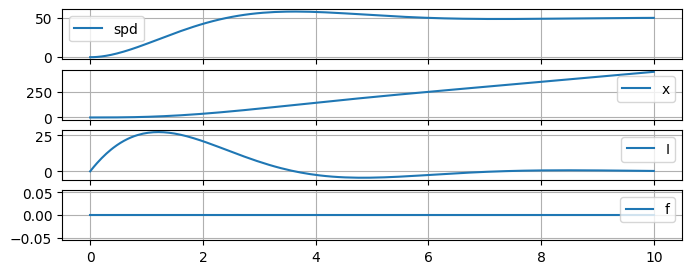

In [13]:
import collimator
import matplotlib.pyplot as plt
from collimator.experimental import AcausalCompiler, AcausalDiagram, EqnEnv
from collimator.experimental import electrical as elec
from collimator.experimental import translational as trn

ev = EqnEnv()
ad = AcausalDiagram()
v = elec.VoltageSource(ev, name="v1", v=50.0, enable_voltage_port=False)
gnd = elec.Ground(ev, name="gnd")
act = LinearActuator(ev, name="act")
motion = trn.MotionSensor(ev, name="motion", enable_flange_b=False, enable_position_port=True)
curr = elec.CurrentSensor(ev, name="curr")

ad.connect(v, "p", curr, "p")
ad.connect(curr, "n", act, "pos")
ad.connect(v, "n", act, "neg")
ad.connect(v, "n", gnd, "p")
ad.connect(act, "flange", motion, "flange_a")

ac = AcausalCompiler(ev, ad)
acausal_system = ac()
builder = collimator.DiagramBuilder()
acausal_system = builder.add(acausal_system)
diagram = builder.build()
context = diagram.create_context(check_types=True)

# run the simulation
spd_idx = acausal_system.outsym_to_portid[motion.get_sym_by_port_name("v_rel")]
x_idx = acausal_system.outsym_to_portid[motion.get_sym_by_port_name("x_rel")]
I_idx = acausal_system.outsym_to_portid[curr.get_sym_by_port_name("i")]
f_idx = acausal_system.outsym_to_portid[act.get_sym_by_port_name("f_out")]
recorded_signals = {
    "spd": acausal_system.output_ports[spd_idx],
    "x": acausal_system.output_ports[x_idx],
    "I": acausal_system.output_ports[I_idx],
    "f": acausal_system.output_ports[f_idx],
}
results = collimator.simulate(
    diagram,
    context,
    (0.0, 10.0),
    recorded_signals=recorded_signals,
)
t = results.time
spd = results.outputs["spd"]
x = results.outputs["x"]
I = results.outputs["I"]  # noqa
f = results.outputs["f"]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 3))
ax1.plot(t, spd, label="spd")
ax1.legend()
ax1.grid()
ax2.plot(t, x, label="x")
ax2.legend()
ax2.grid()
ax3.plot(t, I, label="I")
ax3.legend()
ax3.grid()
ax4.plot(t, f, label="f")
ax4.legend()
ax4.grid()
plt.show()